In [1]:
import os 
import glob
import pandas as pd

import cv2
import numpy as np
#Img Augment

#import imgaug as ia
#import imgaug.augmenters as iaa
#from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
from torch.utils.data import Dataset

from torchsummary import summary

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as T
from sklearn import preprocessing


import matplotlib.patches as patches
import matplotlib.pyplot as plt


from dataload import xml_to_csv,PetData

from tqdm import tqdm


# DATASET SPLIT
![IMG](img/RCNN/DATASET_SPLIT.png)

In [6]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 

train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  
valid1,valid2 = train_test_split(valid, test_size=0.5,random_state=seed)  

BATCH_SIZE = 1
train_ds = PetData(train, train=True,raw_return=True)
valid_ds_1= PetData(valid1, train=True,raw_return=True)
valid_ds_2= PetData(valid2, train=True,raw_return=True)

def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl_1 = torch.utils.data.DataLoader(valid_ds_1, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

valid_dl_2 = torch.utils.data.DataLoader(valid_ds_2, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [7]:
from collections import Counter
print(Counter(train.target))
from collections import Counter
print(Counter(valid1.target))
from collections import Counter
print(Counter(valid2.target))


Counter({1: 833, 0: 830})
Counter({1: 189, 0: 167})
Counter({0: 191, 1: 166})


## Model Workflow
How R-CNN works can be summarized as follows:

1. *Pre-train a CNN* network on image classification tasks; for example, VGG or ResNet trained on ImageNet dataset. The classification task involves N classes.
    NOTE: You can find a pre-trained AlexNet in Caffe Model Zoo. I don’t think you can find it in Tensorflow, but Tensorflow-slim model library provides pre-trained ResNet, VGG, and others.

2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are warped to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a binary SVM trained for each class independently.
6. The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.

## 1. Pretrain a CNN network on image classification

In [8]:
import torch
from torchvision import models

#We used pretrained network from torch
model = models.alexnet(pretrained=True)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(model)}')


Num of parameters: 61100840


## 2. Selective Search from [AlpacaDB](https://github.com/AlpacaDB/selectivesearch)
![SELECTIVE_SEARCH](img/RCNN/SELECTIVE_SEARCH.png)

In [9]:
from utills import ssearch,misc

In [16]:
regions = ssearch.selective_search(train_ds[0][0].numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)

NameError: name 'ssearch' is not defined

In [18]:
len(regions)

2115

## Labeling Negative (iou<0.5), Positive (iou>0.5)

In [19]:
def create_label(proposed_regions,bboxes):
    ''' 
    Adding Labelling to the proposed regions, if iou of prposed_region and actual bounding box of label 'x' is larger than the threshold, we label it as 'x' 
    
    proposed_regions:output of selective_search
    bboxes: ground truth bbox of original img
    '''
    from metrics import iou
    iou_threshold=0.5
    for region in proposed_regions:
        max_iou=0
        
        region['rect']=region['rect'][0],region['rect'][1],region['rect'][2],region['rect'][3]
        region['labels']=-1
        region_tensor=torch.tensor(region['rect'])
        for bbox in bboxes:
            box_tensor=torch.tensor((bbox[0],bbox[1],bbox[2],bbox[3]))
            cur_iou=iou.torch_getIOU(region_tensor,box_tensor)
            if cur_iou>max_iou:
                max_iou=cur_iou
                if max_iou>iou_threshold:
                    region['labels']=bbox[4].item()  
                    
    for bbox in bboxes:
        gt=dict()
        gt["rect"]=(tuple(np.array(bbox[0:4],dtype=np.int)))
        gt["labels"]=bbox[4].item()   
    proposed_regions +=[gt]
        
                    
    return proposed_regions


In [20]:
regions=create_label(regions,train_ds[0][1])
regions=pd.DataFrame.from_dict(regions)
print(f"Before Reduction {len(regions)}")
regions=regions.drop_duplicates(subset=['rect']) #Selective Region algorithm sometimes includes duplicates
print(f"After Reduction {len(regions)}")

Before Reduction 2116
After Reduction 1735


### Visualizing All proposed regions

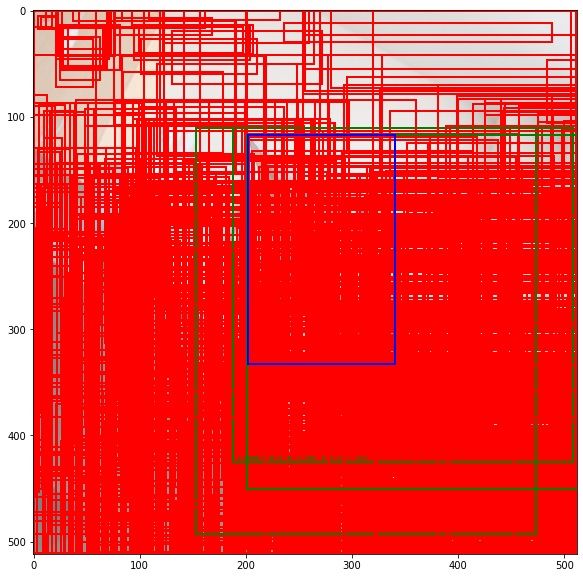

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(train_ds[0][0].numpy().transpose(1,2,0)*0.5+0.5)
for index, i in regions.iterrows():
    color='red'
    if i['labels'] != -1:
        color='green'
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = color,
        fill=False,
        linewidth=2))
for bbox in train_ds[0][1]:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False,
         linewidth=2) )
plt.show()

### Reducing the number of regions (If hardware(ly) limited)

In [22]:
def balance_df(proposed_regions,samples):
    ''' 
    Reducing number of region proposal if hardware limited
    (*this is only for possible for this dataset which always and only have one of its classes (dog,cat) in the image)
    '''
 #   g = proposed_regions.groupby('labels')
  #  g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
#    
    def sampling_k_elements(group, k=samples):
        if len(group) < k:
            return group
        return group.sample(k)
    #return g
    g = proposed_regions.groupby('labels').apply(sampling_k_elements).reset_index(drop=True)
    
    return g

In [23]:
regions=balance_df(regions,50) #Max 50 samples per label 

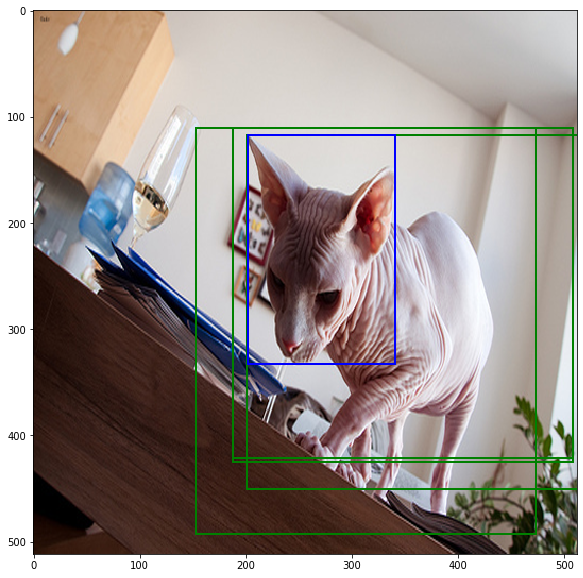

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(train_ds[0][0].numpy().transpose(1,2,0))
for index, i in regions.iterrows():
    color='red'
    if i['labels'] != -1:
        color='green'
    else:
        continue
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = color,
        fill=False,
        linewidth=2))
for bbox in train_ds[0][1]:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False,
         linewidth=2) )
plt.show()

## 3. Region candidates are warped to have a fixed size as required by CNN (16pix of dilation)


In [27]:
#We create another dataset class to be used in training which stores the proposed region dataset
class Sub_region(Dataset):
    def __init__(self, df,img):
        self.src_img=img
        self.df=df
        self.resize=nn.Upsample((224,224))
        self.shape=self.src_img.shape
        self.transforms=T.ToPILImage()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        label=self.df.iloc[idx]['labels']
        rect=self.df.iloc[idx]['rect']
        x1=np.clip(rect[0]-16,0,self.shape[2])
        y1=np.clip(rect[1]-16,0,self.shape[1])
        x2=np.clip(rect[2]+16,0,self.shape[2])
        y2=np.clip(rect[3]+16,0,self.shape[1])
        img=self.resize(self.src_img[:,y1:y2,x1:x2].unsqueeze(0))
        return self.transforms(img.squeeze(0)),label
        #return img.squeeze(0),label


### Savining train set's GT box 

In [29]:
save_root_path="D:/Dataset/Oxford/region_img"
train_df=None

num=0
print("Processing train_dl")
for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(train_dl)):
    gt_regions=[]
    acc_regions=None
    avg_tloss_pimage=0
    for img,bboxes in zip(img_tuple,bbox_tuple):  
        for bbox in bboxes:
            gt=dict()
            gt["rect"]=(tuple(np.array(bbox[0:4],dtype=np.int)))
            gt["labels"]=bbox[4].item()   
            gt_regions +=[gt]
        gt_regions=pd.DataFrame.from_dict(gt_regions)
        gt_regions_ds=Sub_region(gt_regions,img,)        
        for idx,(region_img,label) in enumerate(gt_regions_ds):
            filename_change = str(num).zfill(5) + ".jpg"
            region_data=dict()
            region_data['filename']=filename_change
            region_data['label']=label
            if train_df is None:
                train_df=pd.DataFrame([[filename_change,label]],columns=["filename","labels"])
            else:
                train_df=train_df.append(pd.DataFrame([[filename_change,label]],columns=["filename","labels"]))
            region_img.save(os.path.join(save_root_path,"train",filename_change), "JPEG")
            num=num+1

train_df.to_csv("train_v2.csv",index=False)   

4it [00:00, 35.42it/s]

Processing train_dl


1663it [00:43, 38.44it/s]


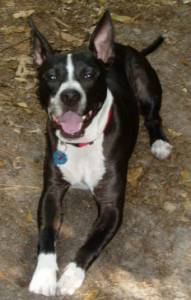

In [37]:
T.ToPILImage()(img_tuple[0]*0.5+0.5)

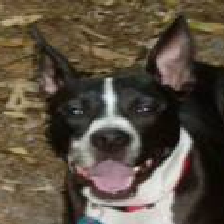

In [38]:
gt_regions_ds[0][0]

### Saviing GT+Selective Regions of valid1 and valid2

In [28]:

save_root_path="D:/Dataset/Oxford/region_img"


valid_df=None

num=0
print("Processing valid_dl_1")

for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(valid_dl_1)):
    acc_regions=None
    avg_tloss_pimage=0
    for img,bbox in zip(img_tuple,bbox_tuple):  

        #regions proposal
        ks = [50]
        regions=[]
        for k in ks:
            regions += ssearch.selective_search(img.numpy().transpose(1,2,0), scale=k, sigma=0.8, min_size=20)
        regions=create_label(regions,bbox)
        regions=pd.DataFrame.from_dict(regions)
        regions=regions.drop_duplicates(subset=['rect']) #Selective Region algorithm sometimes includes duplicates
        #If no true ground_true region is proposed we skip
        regions=balance_df(regions,50)
         #Create Dataset of proposed regions
        region_ds=Sub_region(regions,img)

        for idx,(region_img,label) in enumerate(region_ds):

            filename_change = str(num).zfill(5) + ".jpg"
            region_data=dict()
            region_data['filename']=filename_change
            region_data['label']=label
            if valid_df is None:
                valid_df=pd.DataFrame([[filename_change,label]],columns=["filename","labels"])
            else:
                valid_df=valid_df.append(pd.DataFrame([[filename_change,label]],columns=["filename","labels"]))
            region_img.save(os.path.join(save_root_path,"valid_1",filename_change), "JPEG")
            num=num+1
valid_df.to_csv("valid1_v2.csv",index=False)

print("Processing valid_dl_2")

num=0
valid_df=None

for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(valid_dl_2)):
    acc_regions=None
    avg_tloss_pimage=0
    for img,bbox in zip(img_tuple,bbox_tuple):  

        #Current selective search only works for one_single,
        #so batch_size of original dataset is 1... 
        #which means tuple has only length of 1
        #regions proposal
        ks = [50]
        regions=[]
        for k in ks:
            regions += ssearch.selective_search(img.numpy().transpose(1,2,0), scale=k, sigma=0.8, min_size=20)
        regions=create_label(regions,bbox)
        regions=pd.DataFrame.from_dict(regions)
        regions=regions.drop_duplicates(subset=['rect']) #Selective Region algorithm sometimes includes duplicates
        regions=balance_df(regions,50)
        
         #Create Dataset of proposed regions
        region_ds=Sub_region(regions,img)

        for idx,(region_img,label) in enumerate(region_ds):

            filename_change = str(num).zfill(5) + ".jpg"
            region_data=dict()
            region_data['filename']=filename_change
            region_data['label']=label
            if valid_df is None:
                valid_df=pd.DataFrame([[filename_change,label]],columns=["filename","labels"])
            else:
                valid_df=valid_df.append(pd.DataFrame([[filename_change,label]],columns=["filename","labels"]))
            region_img.save(os.path.join(save_root_path,"valid_2",filename_change), "JPEG")
            num=num+1
valid_df.to_csv("valid2_v2.csv",index=False)

print()


0it [00:00, ?it/s]

Processing valid_dl_1


356it [58:35,  9.88s/it]
0it [00:00, ?it/s]

Processing valid_dl_2


357it [57:30,  9.67s/it]

# Load train,val1,val2 dataset

In [2]:
train_data=pd.read_csv("train_v2.csv")
valid1_data=pd.read_csv("valid1_v2.csv")
valid2_data=pd.read_csv("valid2_v2.csv")

### We concat train_img,valid1_img for finetuning the CNN

In [3]:
train_img_path="D:/Dataset/Oxford/region_img/train/"
valid1_img_path="D:/Dataset/Oxford/region_img/valid_1/"
valid2_img_path="D:/Dataset/Oxford/region_img/valid_2/"

train_data['filename']=train_data.apply(lambda x:train_img_path+ x['filename'],axis=1) #Extra Path added to distiguish train and val 1
valid1_data['filename']=valid1_data.apply(lambda x:valid1_img_path+ x['filename'],axis=1) 
#train_data=train_data.append(valid1_data)

In [4]:
train_data=train_data.append(valid1_data)

### We oversample positive labels to match 1:1:3 ratio 

![OVERSAMPLE](https://i.imgur.com/PfpR7dN.png)

In [5]:
max_size = int((train_data['labels'].value_counts().max())/3)
lst = [train_data]

for class_index, group in train_data.groupby('labels'):
    if class_index==-1:
        continue
    lst.append(group.sample(max_size-len(group), replace=True))
train_data = pd.concat(lst)
train_data=train_data.reset_index()

In [6]:
from PIL import Image

class Sub_region_train(Dataset):
    def __init__(self, df,base_path=None,train=True):
        self.df=df
        self.base_path=base_path
        if train:
            self.transforms=T.Compose([
                 T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ToTensor(),

                T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),

            ])
        else:
            self.transforms=T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),

            ])
        self.le= preprocessing.LabelEncoder()
        self.le=self.le.fit([-1,0,1])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
       # print(self.df.filename[idx])
       # img=cv2.imread(os.path.join(self.base_path,self.df.filename[idx]))
     #   img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=Image.open(os.path.join(self.base_path,self.df.filename[idx]))
        img=self.transforms(img)
        
        return img, self.le.transform([self.df.labels[idx]])[0]
        
        

In [7]:
train_region_ds=Sub_region_train(train_data,"")
valid_region_ds=Sub_region_train(valid2_data,valid2_img_path,train=False)

train_regions_dl =torch.utils.data.DataLoader(train_region_ds, batch_size=128,shuffle=True,drop_last=True)
valid_region_dl =torch.utils.data.DataLoader(valid_region_ds, batch_size=128,shuffle=False,drop_last=True)


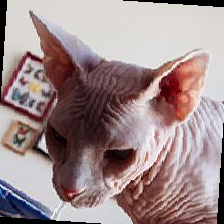

In [8]:
T.ToPILImage()(train_region_ds[0][0]*0.5+0.5)

### We finetune Alexnet network changing only the last layer 

![MODEL PARAMETER](https://i.imgur.com/VZX3rbv.png)

In [9]:
import torch.optim as optim

## Finetuning 

model = models.alexnet(pretrained=True)
model.classifier[6]=nn.Linear(4096,3)
#freeze_some_part
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(model)}')

device='cuda'
model.to(device)
# [-1: background 0: cat, 1: dog]


Num of parameters: 54546435


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
config_=dict()
config_["lr"]=0.001
config_["crit"]=nn.CrossEntropyLoss()
config_["optim"]=optim.SGD(model.parameters(),lr=config_["lr"])
config_["save_dir"]="models/"
config_["epochs"]=300
config_["train_log"]=[]
config_["valid_log"]=[]
config_["train_acc_log"]=[]
config_["valid_acc_log"]=[]
config_["log_interval"]=100
config_["device"]="cuda"
config_["accuracy"]=True

def train(config,train_dl,valid_dl,model):
    '''
    config.optimizer: Training optimizer eg) Adam,SGD....
    config.criterion: Loss eg) CrossEntropy, 
    config.lr: learning_rate
    train_dl,valid_dl: Dataloader
    model: target model
    save_path
    '''
    model.to(config["device"])
    
    for epoch in range(config["epochs"]):
        print()
        print(f'Epochs : {epoch+1}/{config["epochs"]}')
        model.train()
        avg_train_loss=0
        correct=0
        total=0
        for batch_idx,(img,label) in enumerate(train_dl):
            #Zero_grad_Optimizer
            config["optim"].zero_grad()
            img=img.to(config["device"])
            label=label.to(config["device"])
            output=model(img)
            
            #Measure Loss
            loss=config["crit"](output,label)
            loss.backward()
            
            if config["accuracy"]:
                _, predicted = torch.max(output.data, 1)
                total+=label.size()[0]
                correct += (predicted == label).sum().item()
            
            #Update Parameters
            config["optim"].step()
            avg_train_loss+=loss.item()
            if batch_idx % config["log_interval"]==0:
                config["train_log"].append(avg_train_loss/(batch_idx+1))
                config["train_acc_log"].append(correct/(total))
                print(f"Batch {batch_idx+1}/{len(train_dl)} Loss: {loss.item()}, Accuracy {correct/(total)} ")
        model.eval()
        
        valid_loss=0
        correct=0
        total=0
        
        for batch_idx,(img,label) in enumerate(valid_dl):
            
            img=img.to(config["device"])
            label=label.to(config["device"])
            
            output=model(img)
            #Measure Loss
            loss=config["crit"](output,label)
        
            valid_loss+=loss.item()

            if config["accuracy"]:
                _, predicted = torch.max(output.data, 1)
                total+=label.size()[0]
                correct += (predicted == label).sum().item()
        avg_valid_loss=valid_loss/(len(valid_dl))
        config["valid_log"].append(avg_valid_loss)

        
        config["valid_acc_log"].append(correct/total)
        print(f'Validation_Loss: {config["valid_log"][-1]} Validation_Acc: {config["valid_acc_log"][-1]}')
        
        try:
            if max(config["valid_acc_log"][0:-1]) < (correct/total):
                if epoch>50:
                    print()
                    print('Validation Result is better, saving the new model')
                    torch.save(model.state_dict(), config["save_dir"]+f"epoch_{epoch}")
        except:
          #  "First Epoch"
            continue
        
    return config,model
            

In [11]:

config_,model=train(config_,train_regions_dl,valid_region_dl,model)


Epochs : 1/300
Batch 1/231 Loss: 1.2791297435760498, Accuracy 0.2421875 
Batch 101/231 Loss: 0.16182520985603333, Accuracy 0.911509900990099 
Batch 201/231 Loss: 0.1291121244430542, Accuracy 0.9329135572139303 
Validation_Loss: 0.11776231134931246 Validation_Acc: 0.9700520833333334

Epochs : 2/300
Batch 1/231 Loss: 0.14651285111904144, Accuracy 0.9609375 
Batch 101/231 Loss: 0.06864361464977264, Accuracy 0.9614789603960396 
Batch 201/231 Loss: 0.17748737335205078, Accuracy 0.9630363805970149 
Validation_Loss: 0.0990602170303464 Validation_Acc: 0.97328125

Epochs : 3/300
Batch 1/231 Loss: 0.19891706109046936, Accuracy 0.96875 
Batch 101/231 Loss: 0.07375812530517578, Accuracy 0.9681311881188119 
Batch 201/231 Loss: 0.10561634600162506, Accuracy 0.968788868159204 
Validation_Loss: 0.08592050980776549 Validation_Acc: 0.9760416666666667

Epochs : 4/300
Batch 1/231 Loss: 0.102419413626194, Accuracy 0.9765625 
Batch 101/231 Loss: 0.08256547152996063, Accuracy 0.971457301980198 
Batch 201/23

KeyboardInterrupt: 

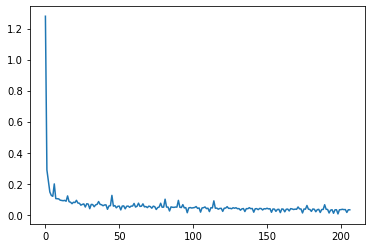

In [12]:
plt.plot(config_["train_log"])

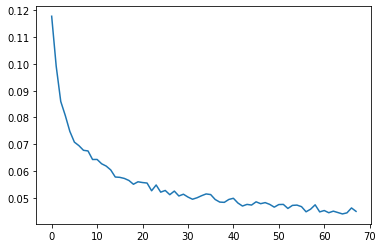

In [13]:
plt.plot(config_["valid_log"])

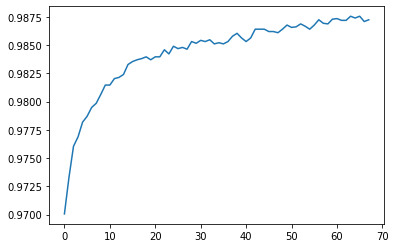

In [14]:
plt.plot(config_["valid_acc_log"])

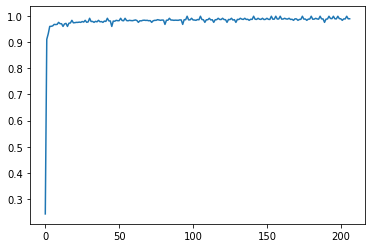

In [15]:
plt.plot(config_["train_acc_log"])